# INFO 2950 Phase 2

## Research question

The film industry is interestingly where art and commerce intersect. Our interaction with film and the industry has been in the context of a consumer. Being able to understand what drives audiences to theaters will allow us to gain a deeper understanding of film through a different perspective. As an industry with so much culture and history, we hope to explore the story of cinema. 

We hope to explore: What key factors influence a movie's box office success, and how do these factors differ across various genres?

## Data collection and cleaning

In [19]:
import numpy as np
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns

### Read Data from CSV Files

In [20]:
movies_data = pd.read_csv("data/movies_metadata.csv")
ratings_data = pd.read_csv("data/ratings_small.csv")

/var/folders/rj/8b1y14lj1rb1yqx9tb_cdshh0000gn/T/ipykernel_2755/2427516042.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_data = pd.read_csv("data/movies_metadata.csv")


In [21]:
print(movies_data.shape)
movies_data.head()

(45466, 24)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [22]:
print(ratings_data.shape)
ratings_data.head()

(100004, 4)


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


### Clean Data

In [23]:
# Filter to select only released movies
movies_data = movies_data[movies_data['status'] == 'Released']

In [24]:
# Drop irrelevant columns
movies_data.drop(columns=['adult', 'homepage', 'status', 'tagline', 'overview', 'poster_path', 'video'], inplace=True)

In [25]:
# Convert release dates to datetime object
print(movies_data['release_date'].dtype)
movies_data['release_date'] = pd.to_datetime(movies_data['release_date'], format='mixed', errors='coerce')
print(movies_data['release_date'].dtype)

object
datetime64[ns]


In [26]:
# Convert id from object to float
print(movies_data['id'].dtype)
movies_data['id'] = pd.to_numeric(movies_data['id'], errors='coerce')
print(movies_data['id'].dtype)

# Convert budget from object to float
print(movies_data['budget'].dtype)
movies_data['budget'] = pd.to_numeric(movies_data['budget'], errors='coerce')
print(movies_data['budget'].dtype)

# Convert popularity from object to float
print(movies_data['popularity'].dtype)
movies_data['popularity'] = pd.to_numeric(movies_data['popularity'], errors='coerce')
print(movies_data['popularity'].dtype)

object
int64
object
int64
object
float64


In [27]:
# Drop rows with missing data
movies_data.dropna(inplace=True)
print(movies_data.shape)

(4457, 17)


In [28]:
# Find average of ratings for each movie
ratings_data = duckdb.sql("SELECT movieId, AVG(rating) AS rating_average, COUNT(rating) AS rating_count FROM ratings_data GROUP BY movieId").df()
ratings_data.head()

,movieId,rating_average,rating_count
0,1061,3.545455,33
1,2105,3.478723,47
2,2294,3.273585,53
3,10,3.450820,122
4,39,3.550000,120


### Create Joined Dataset

In [30]:
# Merge the data frames
data = duckdb.sql("SELECT * FROM movies_data INNER JOIN ratings_data ON movies_data.id = ratings_data.movieId").df()
print(data.shape)
data.drop(columns=['movieId'], inplace=True)
data.head()

(537, 20)


,belongs_to_collection,budget,genres,id,imdb_id,original_language,original_title,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count,rating_average,rating_count
0,"{'id': 2806, 'name': 'American Pie Collection'...",11000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",2105,tt0163651,en,American Pie,18.344227,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'iso_3166_1': 'US', 'name': 'United States o...",1999-07-09,235483004.0,95.0,"[{'iso_639_1': 'en', 'name': 'English'}]",American Pie,6.4,2358.0,3.478723,47
1,"{'id': 133830, 'name': 'Star Wars: The Ewok Ad...",3000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 10751...",1884,tt0087225,en,The Ewok Adventure,5.056089,"[{'name': 'Lucasfilm', 'id': 1}, {'name': 'Kor...","[{'iso_3166_1': 'US', 'name': 'United States o...",1985-02-13,0.0,96.0,"[{'iso_639_1': 'en', 'name': 'English'}]",The Ewok Adventure,5.9,46.0,3.625000,44
2,"{'id': 8650, 'name': 'Transformers Collection'...",150000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 878, ...",1858,tt0418279,en,Transformers,5.587707,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2007-06-27,709709780.0,144.0,"[{'iso_639_1': 'es', 'name': 'Español'}, {'iso...",Transformers,6.6,4113.0,3.416667,6
3,"{'id': 344936, 'name': 'Unna Trilogie', 'poste...",2888030,"[{'id': 80, 'name': 'Crime'}, {'id': 28, 'name...",344,tt0135790,de,Bang Boom Bang - Ein todsicheres Ding,3.931984,"[{'name': 'Senator Film Produktion', 'id': 191...","[{'iso_3166_1': 'DE', 'name': 'Germany'}]",1999-08-26,0.0,110.0,"[{'iso_639_1': 'de', 'name': 'Deutsch'}]","Bang, Boom, Bang",7.5,52.0,2.871429,175
4,"{'id': 221539, 'name': 'Dracula (Universal Ser...",0,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",30793,tt0037793,en,House of Dracula,9.074831,"[{'name': 'Universal Pictures', 'id': 33}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1945-12-06,0.0,67.0,"[{'iso_639_1': 'en', 'name': 'English'}]",House of Dracula,5.8,20.0,3.180851,47


### Data description

**What are the observations (rows) and the attributes (columns)?**  
Rows: each row in the dataset represents a unique movie.  
Columns:
- 'belongs_to_collection': The series that the movie is a part of, if applicable
- 'budget': The budget used to produce the movie, in dollars
- 'genres': The genres that the movie is a part of
- 'id': The identifier for the movie used by MovieLens
- 'imdb_id': The identifier for the movie used by IMDB
- 'original_language': The original language that the movie was produced in
- 'original_title': The original title of the movie
- 'popularity': The popularity of the movie as measured by MovieLens
- 'production_companies': The companies involved in the production of the movie
- 'production_countries': The countries in which the movie was produced
- 'release_date': The date on which the movie was released
- 'revenue': The revenue generated from the movie, in dollars
- 'runtime': The length of the movie, in minutes
- 'spoken_languages': The languages spoken in the movie
- 'title': The title of the movie
- 'vote_average': The average vote of the movie by TMDB users, out of 10
- 'vote_count': The number of votes received by the movie on TMDB
- 'rating_average': The average rating of the movie by MovieLens users, out of 5
- 'rating_count': The number of ratings received by the movie on MovieLens

**Why was this dataset created?**  
This dataset was created by an individual as part of their capstone project for their data science bootcamp. 

**Who funded the creation of the dataset?**  
The individual developed this dataset as part of a project. There was no funding. 

**What processes might have influenced what data was observed and recorded and what was not?**  
The dataset relies solely on APIs from TMDB and GroupLens, which means the quality and completeness of the data depend on how these sources collect and maintain their records. If certain movies are less documented or if there are inconsistencies in data entry, this could result in missing or incomplete metadata. Movie ratings are inherently subjective and can vary significantly based on individual viewer preferences, cultural context, and personal experiences. This subjectivity introduces variability that may not accurately reflect the overall quality or success of a film. 

**What preprocessing was done, and how did the data come to be in the form that you are using?**  
The raw source data was taken from 45,000 movies listed in the Full MovieLens Dataset. The dataset is an ensemble of data collected from TMDB and GroupLens. The Movie Details, Credits and Keywords have been collected from the TMDB Open API. The Movie Links and Ratings have been obtained from the Official GroupLens website. The dataset consists of movies released on or before July 2017. The data has been processed for these specific data points: cast, crew, plot keywords, budget, revenue, posters, release dates, languages, production companies, countries, TMDB vote counts, and vote averages.

**If people are involved, were they aware of the data collection and if so, what purpose did they expect the data to be used for?**  
The individual who created the dataset posted it for public use on Kaggle. There is a CC0: Public Domain license which means this dataset has been dedicated to the public domain because the creator has waived all of their rights to the work worldwide under copyright law. They hope that the dataset can help predict movie revenue/success based on certain metrics. 

**Where can your raw source data be found, if applicable? Provide a link to the raw data.**  
https://grouplens.org/datasets/movielens/latest/

## Data limitations

The dataset that we use will inherently have bias because movie reviews are user-generated and are subjective. Highly-rated movies may attract more votes, while lesser-known films may receive fewer ratings which can skew the average rating of a movie. There could also be temporal bias, where older movies may have fewer ratings or skewed perceptions compared to newer films that have more exposure. Genre classifications can be subjective, leading to inconsistencies in how movies are categorized. Ratings can differ significantly by region or demographic, which is not captured in the dataset. Movie review systems like IMDb are constantly updated, which can lead to versioning issues if datasets are not synchronized properly. Especially because the data contains movies released prior to or on July 2017, this does not account for the most recent movies released.

## Exploratory data analysis

In [12]:
data[['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count', 'average_rating']].describe()

,budget,popularity,revenue,runtime,vote_average,vote_count,average_rating
count,5.370000e+02,537.000000,5.370000e+02,537.000000,537.000000,537.000000,537.000000
mean,2.973849e+07,10.172135,1.288296e+08,105.841713,6.402048,1046.517691,3.337161
std,4.918391e+07,9.414902,2.097305e+08,24.782921,1.056596,1633.912648,0.779324
min,0.000000e+00,0.001908,0.000000e+00,0.000000,0.000000,0.000000,0.500000
25%,0.000000e+00,4.098849,0.000000e+00,92.000000,5.900000,43.000000,3.000000
50%,6.000000e+06,9.356264,3.300000e+07,102.000000,6.500000,383.000000,3.500000
75%,3.700000e+07,13.184585,1.790338e+08,119.000000,7.100000,1225.000000,3.915094
max,3.800000e+08,123.167259,1.118889e+09,240.000000,8.500000,12269.000000,5.000000


Text(0.5, 1.0, 'Revenue of Movies by Budget')

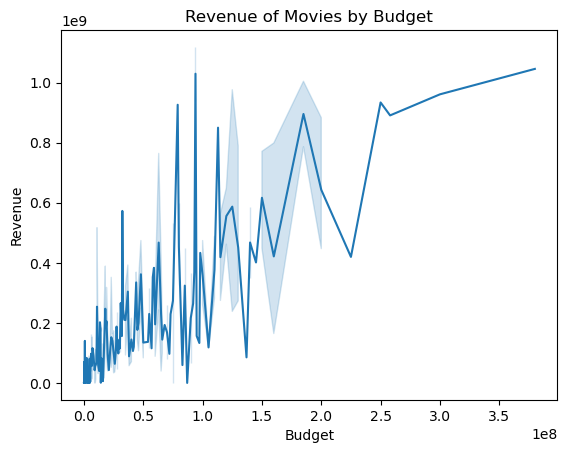

In [16]:
plot = sns.lineplot(data, x='budget', y='revenue')
plt.xlabel('Budget')
plt.ylabel('Revenue')
plt.title('Revenue of Movies by Budget')

Text(0.5, 1.0, 'Popularity of Movies by Runtime')

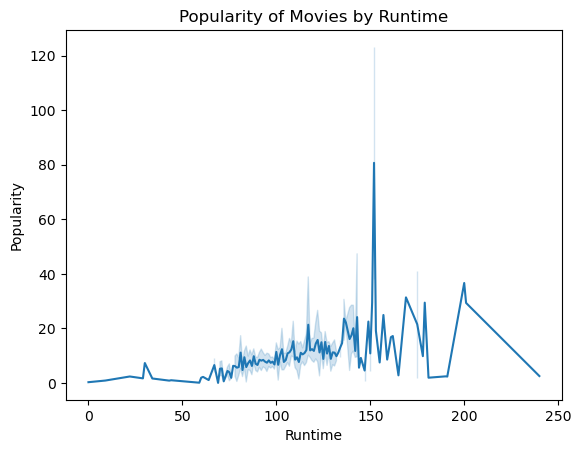

In [14]:
plot = sns.lineplot(data, x='runtime', y='popularity')
plt.xlabel('Runtime')
plt.ylabel('Popularity')
plt.title('Popularity of Movies by Runtime')

Text(0.5, 1.0, 'TMDB Average Vote vs MovieLens Average Rating of Movies')

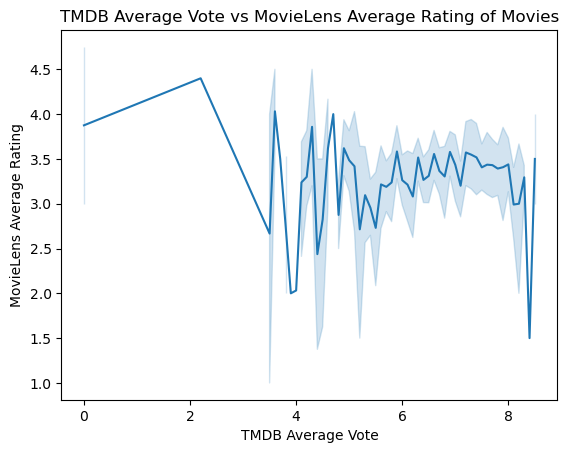

In [15]:
plot = sns.lineplot(data, x='vote_average', y='average_rating')
plt.xlabel('TMDB Average Vote')
plt.ylabel('MovieLens Average Rating')
plt.title('TMDB Average Vote vs MovieLens Average Rating of Movies')

Text(0.5, 1.0, 'Revenue of Movies by Release Date')

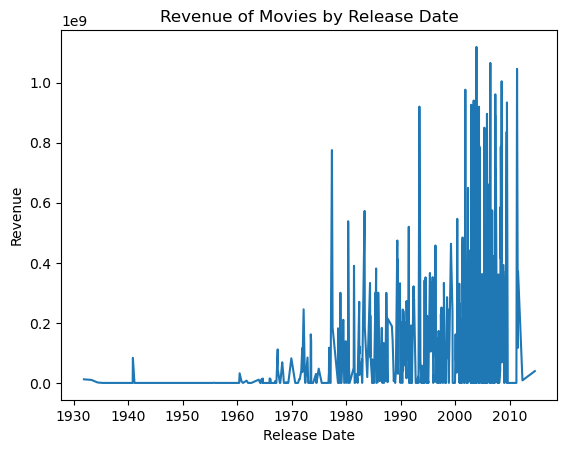

In [24]:
plot = sns.lineplot(data, x='release_date', y='revenue')
plt.xlabel('Release Date')
plt.ylabel('Revenue')
plt.title('Revenue of Movies by Release Date')

## Questions for reviewers

1. Do you find the research question clearly stated? Is it specific enough to guide our analysis?
2. Do you see any potential issues with the data quality or completeness that we should address before proceeding?
3. Do you feel that the data cleaning process is comprehensive enough for the analyses we plan to conduct? Are there any areas you think require more attention?
4. For the next phase, we are planning to use a linear regression predicting revenue and a multivariable regression as our two analyses. Would this be a good approach?